In [201]:
# load a matrix from a space-separated file and show it as an image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import sys
sys.path.append('../..')
sys.path.append('/homes/ar2342/one_more_dir/contextual_frogs/')
from models import ElboGenerativeModelTop
from types import SimpleNamespace


In [202]:
def mean_per_key(data):
    keys = list(data[1].keys())
    mean_data = {}
    for key in keys:
        all_values = []
        for i in range(1,17):
            all_values.append(data[i][key].mean(axis=1))
        mean_data[key] = np.mean(all_values, axis=0)
    return mean_data

In [203]:
sys.path.append('/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/')
from optimise_clnn import eval_paradigms

In [204]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args = SimpleNamespace(model='default',
                       enable_q_scale_tuning=False,
                       assume_opt_output_noise=True, 
                       enable_qlpf=False,
                       enable_ylpf=False,
                       paradigm_file='/homes/ar2342/one_more_dir/contextual_frogs/signoffrepertoire4.pkl',
                       noise_injection_node='u',
                       model_tie_lr_weight_decay=True,
                       bs=512,
                       n=128)
model = ElboGenerativeModelTop(device=device, args=args)

In [205]:
with torch.no_grad():
    for name, p in model.named_parameters():
        if name == 'log_learning_rate_decay':
            p.fill_(-1.0) 
        if name == 'log_learning_rate':
            p.fill_(-6.9) 
        if name == 'log_weight_decay':
            p.fill_(-0.005) 

In [206]:
model.state_dict()

OrderedDict([('log_learning_rate', tensor([-6.9000], device='cuda:0')),
             ('log_learning_rate_decay', tensor([-1.], device='cuda:0')),
             ('sigma_b', tensor([0.1000], device='cuda:0')),
             ('output_scale', tensor([1.], device='cuda:0')),
             ('log_weight_decay', tensor([-0.0050], device='cuda:0')),
             ('sigma_x', tensor([0.1000], device='cuda:0')),
             ('_z_biases', tensor([])),
             ('_w_in', tensor([])),
             ('_w_inq', tensor([]))])

In [207]:


ooo = eval_paradigms(model,args.paradigm_file,args)

evaluating paradigm savings with 440 steps
evaluating paradigm AB0 with 270 steps
evaluating paradigm AB1 with 283 steps
evaluating paradigm AB2 with 311 steps
evaluating paradigm AB3 with 382 steps
evaluating paradigm AB4 with 500 steps
evaluating paradigm AB5 with 680 steps
evaluating paradigm herzfeld,z=0.1$0 with 1125 steps
evaluating paradigm herzfeld,z=0.5$0 with 1125 steps
evaluating paradigm herzfeld,z=0.9$0 with 1125 steps
evaluating paradigm herzfeld,z=0.1$1 with 1125 steps
evaluating paradigm herzfeld,z=0.5$1 with 1125 steps
evaluating paradigm herzfeld,z=0.9$1 with 1125 steps
evaluating paradigm herzfeld,z=0.1$2 with 1125 steps
evaluating paradigm herzfeld,z=0.5$2 with 1125 steps
evaluating paradigm herzfeld,z=0.9$2 with 1125 steps
evaluating paradigm herzfeld,z=0.1$3 with 1125 steps
evaluating paradigm herzfeld,z=0.5$3 with 1125 steps
evaluating paradigm herzfeld,z=0.9$3 with 1125 steps
evaluating paradigm herzfeld,z=0.1$4 with 1125 steps
evaluating paradigm herzfeld,z=0.5

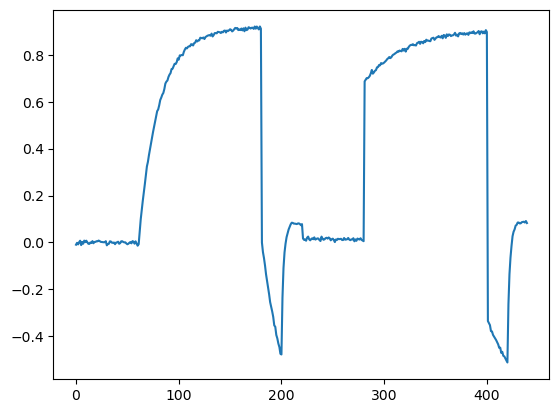

In [208]:
# for key in data:
plt.figure()
plt.plot(ooo['savings'].mean(axis=1))


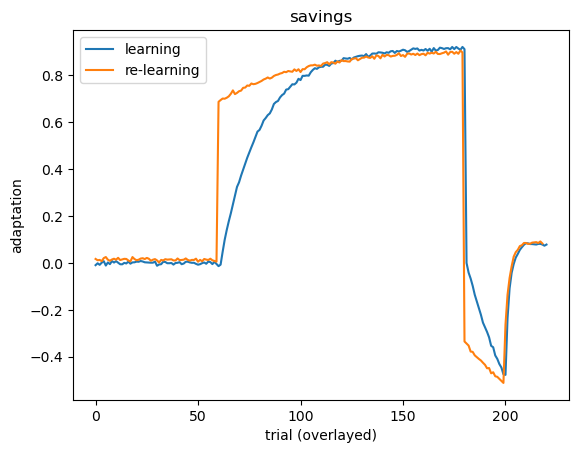

In [209]:
plt.plot(ooo['savings'][:221].mean(axis=1) , label='learning')
plt.plot(ooo['savings'][221:].mean(axis=1), label='re-learning')
plt.title('savings')
plt.xlabel('trial (overlayed)')
plt.ylabel('adaptation')
plt.legend()

<Figure size 640x480 with 0 Axes>

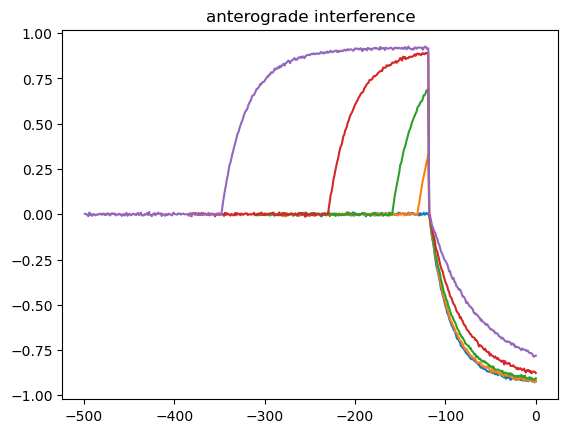

In [210]:
ant_list = [f'AB{i}' for i in range(0,5)]
plt.figure()
plt.figure()
plt.title('anterograde interference')
for ant in ant_list:
    x_data = np.arange(len(ooo[ant].mean(axis=1)))
    plt.plot(x_data-np.max(x_data),ooo[ant].mean(axis=1))

Text(0.5, 1.0, 'environmental consistency')

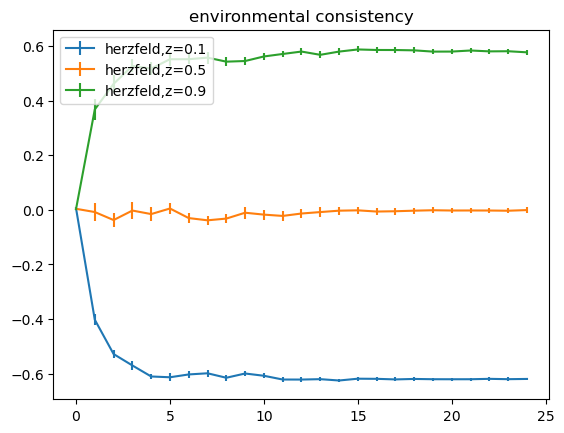

In [219]:
deltas_by_super_scenario = {}
for i, this_data in enumerate([ooo]):
    # plt.subplot(4,4,i+1)
    for iz, z in enumerate(ooo.keys()):
        if 'herzfeld' not in z:
            continue
        else:
            scenario = z
            super_scenario = z.split('$')[0]
        deltas = []
        mm = lambda x: np.mean(x,axis=0)
        # scenario = f'herzfeld,z={z}'
        this_result = this_data[scenario].mean(axis=1)
        pointer = 0
        for bb in range(25):
            block_length = len(this_result)//25
            # pointer += block_length
            # deltas.append(this_result[pointer-1]-this_result[pointer-3])
            deltas.append(this_result[pointer+2]-this_result[pointer])
            pointer += block_length

        if super_scenario not in deltas_by_super_scenario:
            deltas_by_super_scenario[super_scenario] = []
        deltas_by_super_scenario[super_scenario].append(deltas)
        # plt.plot(deltas,'x',label = f'z={z}')
        # plt.title('environmental consistency')
    # plt.legend(loc='upper right')
plt.figure()
for k in deltas_by_super_scenario:
    # plt.plot(np.mean(deltas_by_super_scenario[k],axis=0),label=k)
    #present with error bars
    data = np.array(deltas_by_super_scenario[k])
    mean = np.mean(data,axis=0)
    std = np.std(data,axis=0)
    plt.errorbar(np.arange(len(mean)),mean,yerr=std/np.sqrt(data.shape[0]),label=k)

plt.legend()
plt.title('environmental consistency')
# plt.xlim(0,6)

In [220]:
import pickle
with open('oooo_signoff.pkl','wb') as f:
    pickle.dump(ooo,f)